In [1]:
from swat import *
from pprint import pprint

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


In [3]:
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.lr_scheduler import *
from dlpy.images import *
from dlpy.image_embedding import *
from dlpy.embedding_model import EmbeddingModel

In [4]:
s = CAS('host_name', port_number)
s.sessionprop.setsessopt(caslib='CASUSER', timeout=31535000)

NOTE: 'CASUSER(userid)' is now the active caslib.


+ Elapsed: 0.000171s, user: 4.6e-05s, sys: 0.000108s, mem: 0.274mb

# Prepare the data for training a triplet model

In [5]:
my_table= ImageEmbeddingTable.load_files(s, path='server_side_data_path', 
                                         embedding_model_type='triplet', label_level=-2)

In [6]:
# checl the label information for the image triplets
my_table.label_freq[3]

,Level,Frequency
"german_shepherd,german_shepherd,german_shepherd",1,8
"german_shepherd,german_shepherd,golden_retriever",2,10
"german_shepherd,german_shepherd,labrador_retriever",3,10
"german_shepherd,german_shepherd,miniature_poodle",4,9
"german_shepherd,german_shepherd,soft-coated_wheaten_terrier",5,19
"german_shepherd,german_shepherd,toy_poodle",6,18
"golden_retriever,golden_retriever,german_shepherd",7,11
"golden_retriever,golden_retriever,golden_retriever",8,8
"golden_retriever,golden_retriever,labrador_retriever",9,10
"golden_retriever,golden_retriever,miniature_poodle",10,8


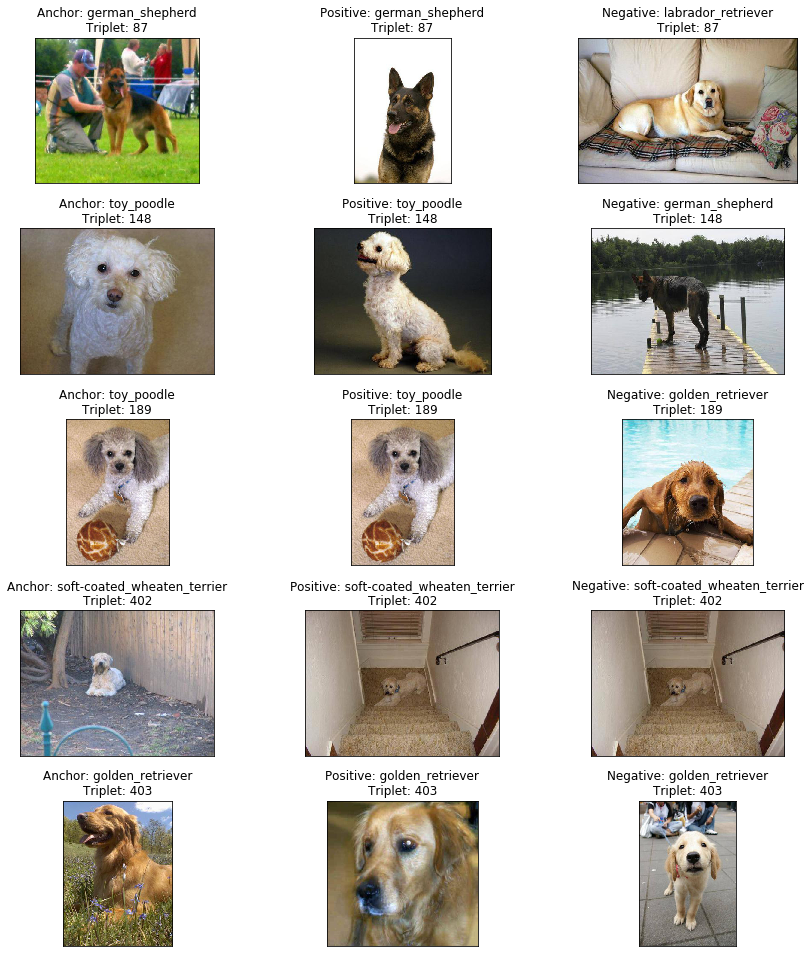

In [7]:
# display some image triplets
my_table.show()

In [8]:
my_table.numrows()

[numrows]

 512

+ Elapsed: 0.000211s, user: 2e-05s, sys: 0.000176s, mem: 0.417mb

# Build a triplet model using ResNet18 as the base branch

In [9]:
#build the base model
resnet18_model = ResNet18_Caffe(s,
                                width=224,
                                height=224,
                                random_crop='RESIZETHENCROP',
                                random_mutation='random'
                                )

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


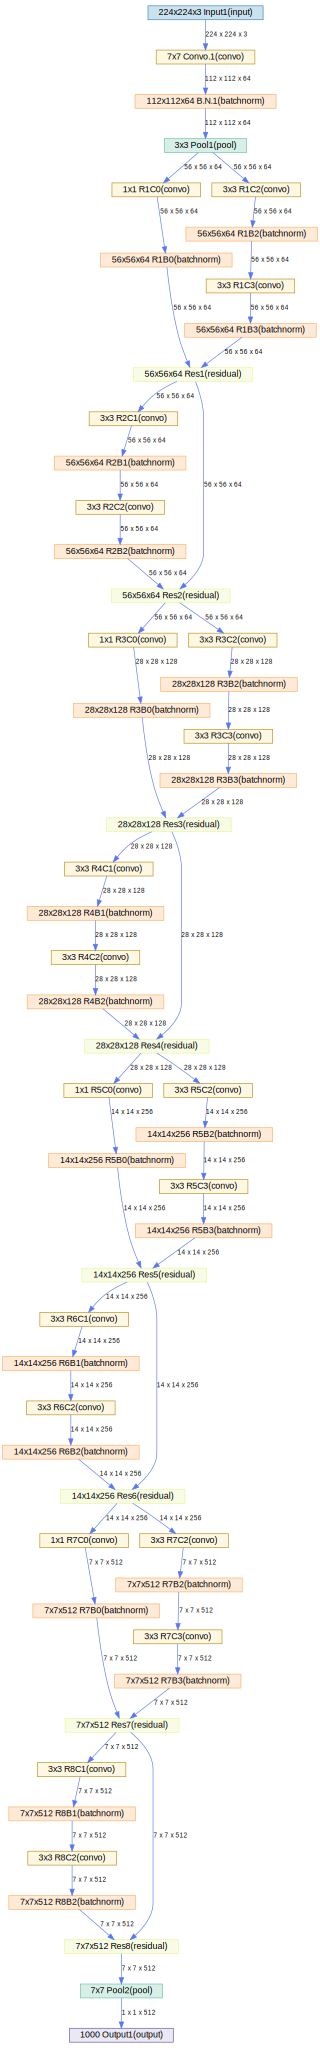

In [10]:
resnet18_model.plot_network()

In [11]:
# define the embedding layer with 4 neurons
# if this is not given, the last layer before the output layer will be used as the embedding layer
embedding_layer = Dense(n=4, act='identity')

In [12]:
# build a triplet model
model_tr = EmbeddingModel.build_embedding_model(resnet18_model, model_table='test_tr',
                                              embedding_model_type='triplet', margin=-3.0,
                                              embedding_layer=embedding_layer)

NOTE: Convert the branch model into a functional model.
NOTE: Remove the output layers from the model.
NOTE: Model compiled successfully.


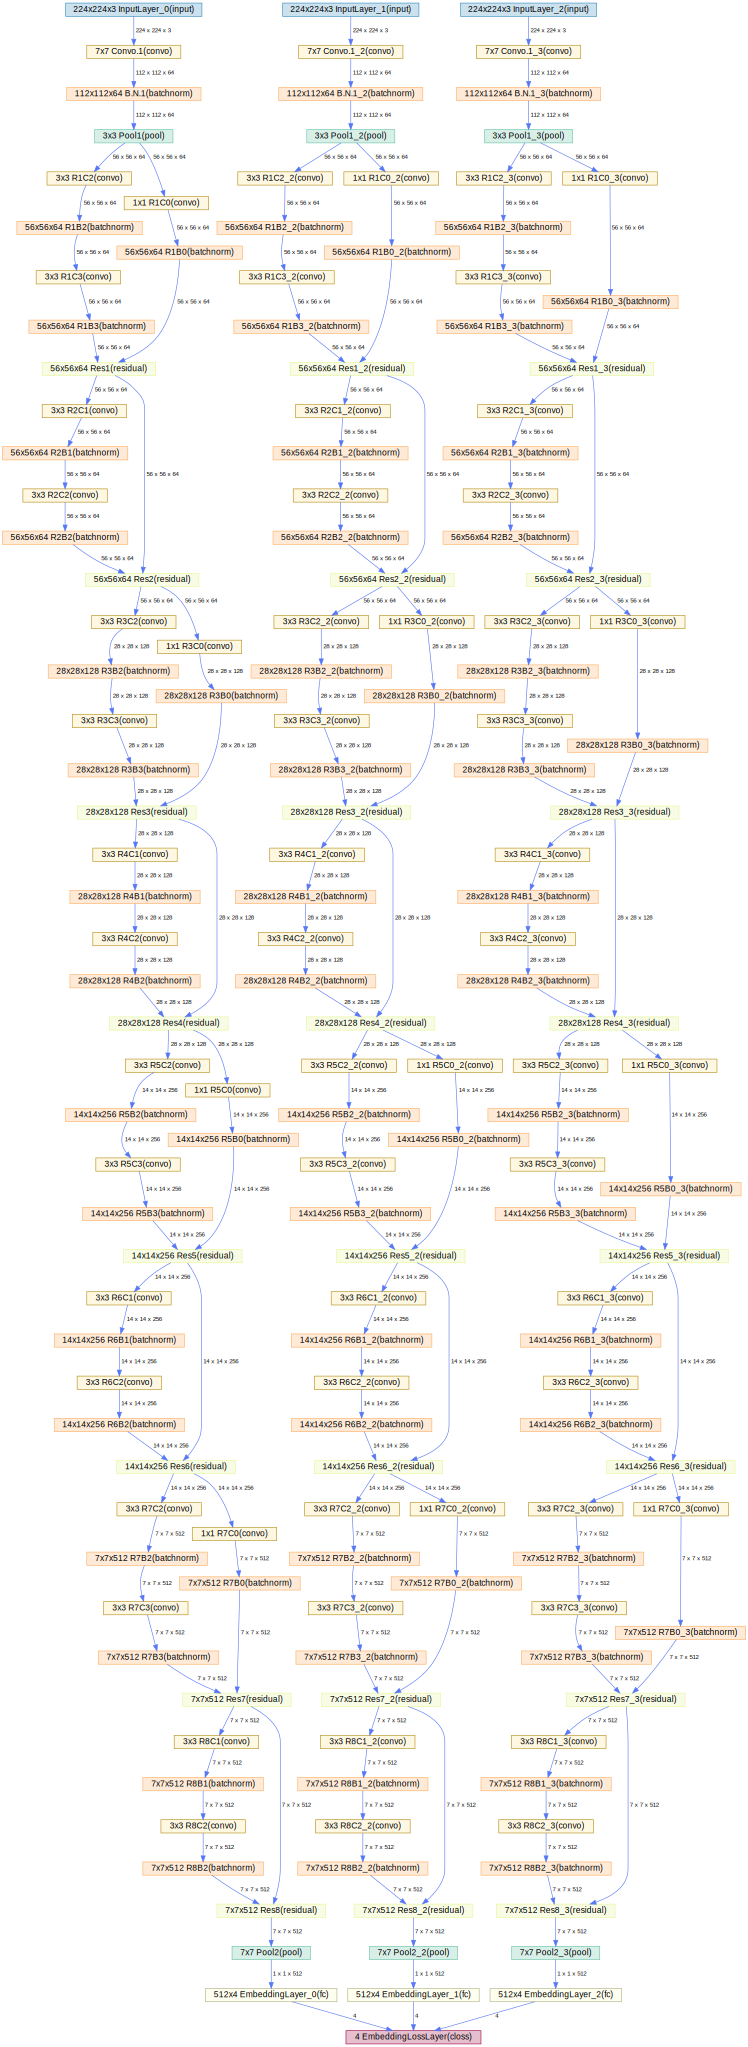

In [13]:
model_tr.plot_network()

# Train the model

In [14]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)

In [15]:
from dlpy.model import Optimizer, MomentumSolver, AdamSolver
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=20), clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=8, log_level=2, max_epochs=40, reg_l2=0.0001)

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [16]:
# train the model using fit_embedding_model, which automatically binds 
# the input and output information from the image embedding table to the model
model_tr.fit_embedding_model(data=my_table, optimizer=optimizer, n_threads=4, gpu=gpu, seed=1234,record_seed=23435)

NOTE: Training from scratch.
NOTE: Using host_name: 1 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 33548364.
NOTE:  The approximate memory cost is 885.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.54 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 8.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0        0.0001           0.633      3.258     6.86
NOTE:  1        0.0001          0.2079      2.437     3.33
NOTE:  2        0.0001         0.03407      1.557     3.40
NOTE:  3        0.0001        -0.01989      1.375     3.38
NOTE:  4        0.0001        -0.03467      1.877     3.23
NOTE:  5        0.0001        -0.01692       1.93     3.29
NOTE:  6        0.0001         0.04186      2.032     3.27
NO

,Descr,Value
0,Model Name,test_tr
1,Model Type,Convolutional Neural Network
2,Number of Layers,163
3,Number of Input Layers,3
4,Number of Output Layers,0
5,Number of Convolutional Layers,63
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,3
8,Number of Batch Normalization Layers,63
9,Number of Residual Layers,24


# Assess the model

In [17]:
# randomly generate another data set to assess the model
my_table_test= ImageEmbeddingTable.load_files(s, path='/cas/DeepLearn/dlpy/DogBreed_small', 
                                              embedding_model_type='triplet', label_level=-2, 
                                              n_samples=64)

In [18]:
from dlpy.model import Gpu
gpu = Gpu(devices=1)
model_tr.predict(data=my_table_test, gpu=gpu, random_crop='RESIZETHENCROP')

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Using host_name: 1 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            64
 1  Number of Observations Used            64
 2          Mean Absolute Error      4.919432
 3                   Loss Error      -0.58843

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(userid)  Valid_Res_oCmbEz    64       21   
 
                                                  casTable  
 0  CASTable('Valid_Res_oCmbEz', caslib='CASUSER(userid)')  

+ Elapsed: 5.4s, user: 5.76s, sys: 2.69s, mem: 1.43e+03mb

In [19]:
# '_DL_Pred0_' contains the predicted distance between anchor and positive samples
# '_DL_Pred1_' contains the predicted distance between anchor and negative samples
# if the model learns good features, '_DL_Pred0_' is usually smaller than '_DL_Pred1_'
# here we look at the mean values
s.summary(table=model_tr.valid_res_tbl, inputs=['_DL_Pred0_', '_DL_Pred1_'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,_DL_Pred0_,0.864470,4.521181,64.0,0.0,2.153114,137.799265,0.863179,0.107897,0.745078,343.637346,46.939888,40.089794,19.955204,6.277721e-29,0.515996,-0.467088
1,_DL_Pred1_,0.584207,5.807419,64.0,0.0,2.766318,177.044352,1.178574,0.147322,1.389036,577.270263,87.509286,42.604424,18.777393,1.683911e-27,0.404269,-0.529558


In [20]:
# check the image rankings
tot_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name))
correctly_ranked_obs = s.numrows(table=dict(name=model_tr.valid_res_tbl.name, where='_DL_Pred0_ < _DL_Pred1_'))

In [21]:
# most of images are ranked correctly for this toy data set
correctly_ranked_obs['numrows']/tot_obs['numrows']

0.65625

In [22]:
# close the session
s.endsession()

+ Elapsed: 0.0001s, user: 7.8e-05s, sys: 5e-06s, mem: 0.221mb